# Examples of structural change in the Abel-Hayashi "Q" investment model

This notebook illustrates the dynamic behavior of capital and its marginal
value in the Abel-Hayashi model of investment when structural changes happen.

I simulate the changes discussed in Prof. Christopher D. Carroll's graduate
Macroeconomics [lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Investment/qModel/):
productivity, corporate tax rate, and investment tax credit changes.

For each change I display the behavior of the model in two different
contexts:
* The change takes place at $t=0$ without notice.
* The change is announced at $t=0$ but takes place at $t=5$.

In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import optimize

from Q_investment import Qmod

from dolo import *
import dolo.algos.perfect_foresight as pf
import dolo.algos.value_iteration as vi

import pandas as pd

I first define functions to compute and present optimal dynamics in face of
structural changes in the Qmod implementation.

In [2]:
# Function definitions
def pathValue(invest,mod1,mod2,k0,t):
    '''
    Computes the value of taking investment decisions [i(0),i(1),...,i(t-1)]
    starting at capital k0 and knowing that the prevailing model will switch
    from mod1 to mod2 at time t.
    
    Parameters:
        - invest: vector/list with investment values for periods 0 to t-1
        - mod1  : Qmod object representing the parameter values prevailing from
                  time 0 to t-1.
        - mod2  : Qmod object representing the parameter values prevailing from
                  time t onwards.
        - k0    : capital at time 0.
        - t     : time of the structural change.
    '''
    
    # Initialize capital and value (utility)
    k = np.zeros(t+1)
    k[0] = k0
    value = 0
    
    # Compute capital and utility flows until time t-1
    for i in range(t):
        flow = mod1.flow(k[i],invest[i])
        value += flow*mod1.beta**i
        k[i+1] = k[i]*(1-mod1.delta) + invest[i]
    
    # From time t onwards, model 2 prevails and its value function can be used.
    value += (mod1.beta**t)*mod2.value_func(k[t])
    
    return(value)
            
def structural_change(mod1,mod2,k0,t_change,T_sim,npoints = 300):
    """
    Computes (optimal) capital and lambda dynamics in face of a structural
    change in the Q investment model.
    
    Parameters:
        - mod1    : Qmod object representing the parameter values prevailing
                    from time 0 to t_change-1.
        - mod2    : Qmod object representing the parameter values prevailing
                    from time t_change onwards.
        - k0      : initial value for capital.
        - t_change: time period at which the structural change takes place. It
                    is assumed that the change is announced at period 0.
        - T_sim   : final time period of the simulation.
        - npoints : number of points in the capital grid to be used for phase
                    diagram plots.
    """
    
    # If the change is announced with anticipation, the optimal path of
    # investment from 0 to t_change-1 is computed, as it does not correspond to
    # the usual policy rule.
    if t_change > 0:
        fobj = lambda x: -1*pathValue(x,mod1,mod2,k0,t_change)
        inv = optimize.minimize(fobj,x0 = np.ones(t)*mod1.kss*mod2.delta,
                                options = {'disp': True},
                                tol = 1e-16).x
    
    # Find paths of capital and lambda
    k = np.zeros(T_sim)
    lam = np.zeros(T_sim)
    k[0] = k0 
    for i in range(0,T_sim-1):
    
        if i < t_change:
            # Before the change, investment follows the optimal
            # path computed above.
            k[i+1] = k[i]*(1-mod1.delta) + inv[i]
            lam[i] = mod1.findLambda(k[i],k[i+1])
        else:
            # After the change, investment follows the post-change policy rule.
            k[i+1] = mod2.k1Func(k[i])
            lam[i] = mod2.findLambda(k[i],k[i+1])
    
    lam[T_sim-1] = mod2.findLambda(k[T_sim-1],mod2.k1Func(k[T_sim-1]))
    
    # Create a figure with phase diagrams and dynamics.
    plt.figure()
    
    # Plot k,lambda path.
    plt.plot(k,lam,'.k')
    plt.plot(k[t_change],lam[t_change],'.r',label = 'Change takes effect')
    
    # Plot the loci of the pre and post-change models.
    k_range = np.linspace(0.1*min(mod1.kss,mod2.kss),2*max(mod1.kss,mod2.kss),
                          npoints)
    mods = [mod1,mod2]
    colors = ['r','b']
    labels = ['Pre-change','Post-change']
    for i in range(2):

        # Plot k0 locus
        plt.plot(k_range,mods[i].P*np.ones(npoints),
                 linestyle = '--', color = colors[i],label = labels[i])
        # Plot lambda0 locus
        plt.plot(k_range,[mods[i].lambda0locus(x) for x in k_range],
                 linestyle = '--', color = colors[i])
        # Plot steady state
        plt.plot(mods[i].kss,mods[i].P,marker = '*', color = colors[i])
    
    plt.title('Phase diagrams and model dynamics')
    plt.xlabel('K')
    plt.ylabel('Lambda')
    plt.legend()
    
    return((k,lam))

I now define functions to handle parameter changes in the Dolo implementation

In [3]:
def simul_change_dolo(model, k0,  exog0, exog1, t_change, T_sim):
    
    # The first step is to create time series for the exogenous variables
    exog = np.array([exog1,]*(T_sim - t_change))
    if t_change > 0:
        exog = np.concatenate((np.array([exog0,]*(t_change)),
                               exog),
                              axis = 0)
    
    exog = pd.DataFrame(exog, columns = ['R','tau','itc_1','psi'])
    
    # Simpulate the optimal response
    dr = pf.deterministic_solve(model = model,shocks = exog, T=T_sim,
                                verbose=True, s1 = k0)
    
    return(dr[1:])

In [4]:
# Create a base Q model with the Python class and Dolo using the
# same parametrization.

# Base parameters

# Discount factor and interest factor
beta = 0.98
R = 1/beta
# Tax rate
tau = 0.05
# Share of capital in production
alpha = 0.33
# Adjustment costs
omega = 1
# Investment tax credit
zeta = 0
# Depreciation rate
delta = 0.1
# Technological factor
psi = 1

# Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()
# Dolo
QDolo = yaml_import("Dolo/Q_model.yaml")

# We do not pass psi, tau, or zeta since they are handled not as parameters
# but exogenous variables.
QDolo.set_calibration(R = R, alpha = alpha, delta = delta, omega = omega)

    calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


## Examples:

## 1. An unanticipated increase in productivity

	> 1 | 0.14676772832327756 | 0
	> 2 | 0.05856537004424045 | 0
	> 3 | 0.01559187362018788 | 0
	> 4 | 0.0015131650449734524 | 0
	> 5 | 1.461287085779972e-05 | 0
	> 6 | 1.2078567035445076e-09 | 0
> System was solved after iteration 6. Residual=1.2078567035445076e-09


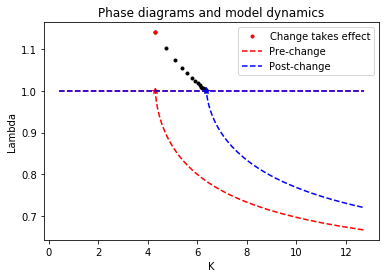

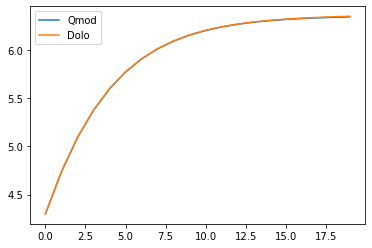

In [5]:
t = 0
T = 20
k0 = Qmodel.kss

psi_new = 1.3

# Qmod class

# Copy the initial model, set a higher psi and re-solve
Q_high_psi = deepcopy(Qmodel)
Q_high_psi.psi = psi_new
Q_high_psi.solve()

sol = structural_change(mod1 = Qmodel, mod2 = Q_high_psi,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,zeta,psi_new],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol[0], label = 'Qmod')
plt.plot(time, soldolo['k'], label = 'Dolo')
plt.legend()

## 2. An increase in productivity announced at t=0 but taking effect at t=5

         Current function value: -78.057692
         Iterations: 17
         Function evaluations: 428
         Gradient evaluations: 61
	> 1 | 0.14676465447356568 | 0
	> 2 | 0.058552742952532766 | 0
	> 3 | 0.015573546844869002 | 0
	> 4 | 0.0015075354377829253 | 0
	> 5 | 1.4477731421269624e-05 | 0
	> 6 | 1.147427930447975e-09 | 0
> System was solved after iteration 6. Residual=1.147427930447975e-09


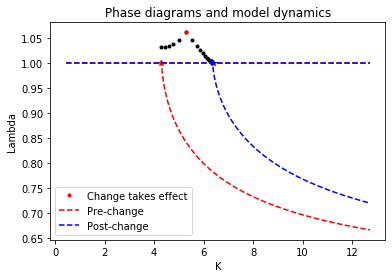

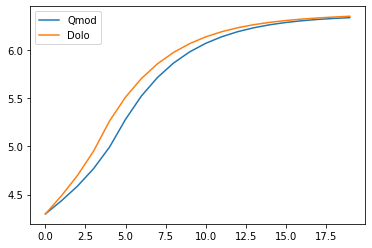

In [6]:
# Repeat the calculation now assuming the change happens at t=5
t = 5

# Qmod class
sol = structural_change(mod1 = Qmodel, mod2 = Q_high_psi,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,zeta,psi_new],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol[0], label = 'Qmod')
plt.plot(time, soldolo['k'], label = 'Dolo')
plt.legend()

## 3. An unanticipated corporate tax-cut

         Current function value: -51.110475
         Iterations: 11
         Function evaluations: 571
         Gradient evaluations: 80
	> 1 | 0.08775916530262984 | 0
	> 2 | 0.029652700258984366 | 0
	> 3 | 0.0055085146890541115 | 0
	> 4 | 0.00024043736490853007 | 0
	> 5 | 4.383555940457029e-07 | 0
> System was solved after iteration 5. Residual=4.383555940457029e-07


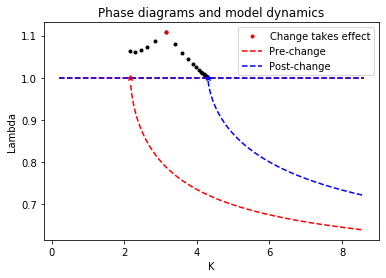

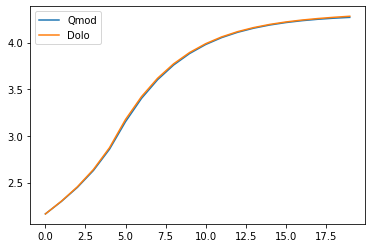

In [7]:
tau_high = 0.4

# Qmod class

# Copy the initial model, set a higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_high
Q_high_tau.solve()

k0 = Q_high_tau.kss

sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau_high,zeta,psi],
                            exog1 = [R,tau,zeta,psi],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol[0], label = 'Qmod')
plt.plot(time, soldolo['k'], label = 'Dolo')
plt.legend()

## 4. A corporate tax cut announced at t=0 but taking effect at t=5

         Current function value: -51.110475
         Iterations: 11
         Function evaluations: 571
         Gradient evaluations: 80
	> 1 | 0.08775916530262984 | 0
	> 2 | 0.029652700258984366 | 0
	> 3 | 0.0055085146890541115 | 0
	> 4 | 0.00024043736490853007 | 0
	> 5 | 4.383555940457029e-07 | 0
> System was solved after iteration 5. Residual=4.383555940457029e-07


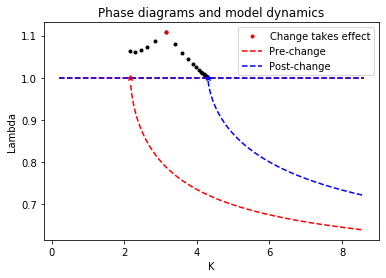

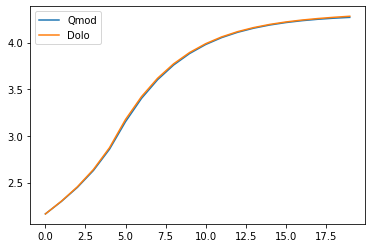

In [8]:
t = 5

sol = structural_change(mod1 = Q_high_tau, mod2 = Qmodel,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau_high,zeta,psi],
                            exog1 = [R,tau,zeta,psi],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol[0], label = 'Qmod')
plt.plot(time, soldolo['k'], label = 'Dolo')
plt.legend()

## 5. An unanticipated ITC increase

	> 1 | 0.12736025161576647 | 0
	> 2 | 0.051526266420397704 | 0
	> 3 | 0.01259981905136276 | 0
	> 4 | 0.000969835034965838 | 0
	> 5 | 5.6561323638071315e-06 | 0
	> 6 | 1.583770892210623e-10 | 0
> System was solved after iteration 6. Residual=1.583770892210623e-10


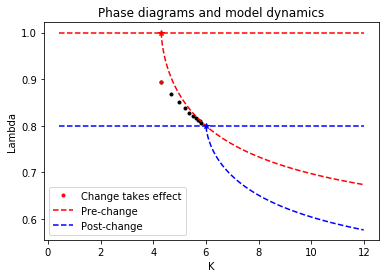

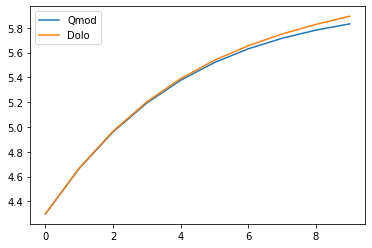

In [11]:
t=0
itc_high = 0.2

# Qmod class

# Copy the initial model, set a higher psi and re-solve
Q_high_itc = deepcopy(Qmodel)
Q_high_itc.zeta = itc_high
Q_high_itc.solve()

k0 = Qmodel.kss

sol = structural_change(mod1 = Qmodel, mod2 = Q_high_itc,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,itc_high,psi],
                            t_change = t, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol[0], label = 'Qmod')
plt.plot(time, soldolo['k'], label = 'Dolo')
plt.legend()

## 6. An ITC increase announced at t=0 but taking effect at t=5

         Current function value: -60.398780
         Iterations: 20
         Function evaluations: 162
         Gradient evaluations: 23
	> 1 | 0.12414254536158853 | 0
	> 2 | 0.04625522695806594 | 0
	> 3 | 0.009407267363871097 | 0
	> 4 | 0.00048328740106895474 | 0
	> 5 | 1.2128367130603834e-06 | 0
	> 6 | 5.9355853565534744e-12 | 0
> System was solved after iteration 6. Residual=5.9355853565534744e-12
         Current function value: -60.398780
         Iterations: 20
         Function evaluations: 162
         Gradient evaluations: 23


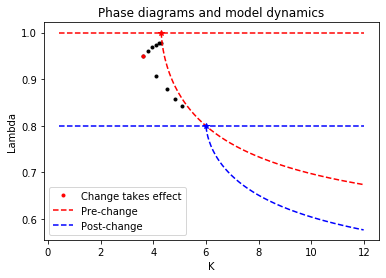

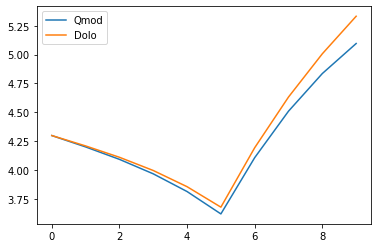

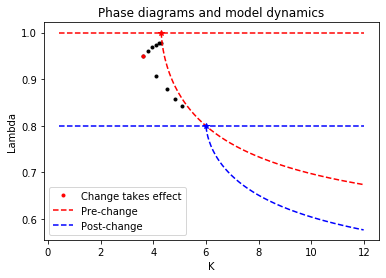

In [14]:
t = 5

sol = structural_change(mod1 = Qmodel, mod2 = Q_high_itc,
                        k0 = k0, t_change = t,T_sim=T)

# Dolo
soldolo = simul_change_dolo(model = QDolo, k0 = np.array([k0]),
                            exog0 = [R,tau,zeta,psi],
                            exog1 = [R,tau,itc_high,psi],
                            t_change = t+1, T_sim = T)

# Plot the path of capital under both solutions
time = range(T)
plt.figure()
plt.plot(time, sol[0], label = 'Qmod')
plt.plot(time, soldolo['k'], label = 'Dolo')
plt.legend()